In [5]:
import pathlib
import sys
import numpy as np
import tensorflow as tf
from model.model import Encoders, NN
from model import utils
import pandas as pd
import pylab as plt
path = pathlib.Path.cwd()
if path.stem == 'DeepTMB':
    cwd = path
else:
    cwd = list(path.parents)[::-1][path.parts.index('DeepTMB')]
    sys.path.append(str(cwd))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[-2], True)
tf.config.experimental.set_visible_devices(physical_devices[-2], 'GPU')

## Read data.  This data is panel-derived TMB (nonsyn per Mb of panel) and matching exomic values (nonsyn per Mb of exome).

In [6]:
data = pd.read_csv(cwd / 'example' / 'example_training_data.txt', sep=',')

## Create arrays for x and y.

In [7]:
X = data['panel_values'].values
Y = data['exome_values'].values

## No weighting in this example. If there is a region of TMB that is of interest weighting can be used to ensure the model focuses on that region.

In [8]:
y_weights = np.ones_like(Y)

## Log transform and make loaders.  Training with log-transformed data helps avoid issues with large values.  We perform a log transformation that prevents any values from becoming negative.  We cannot allow for negative values because the mixture model uses log-normal distributions, which are only defined for positive values.  The loaders are overkill for this example, but if desired the loaders can perform complex operations such as data augmentation on a per batch basis.

In [9]:
t = utils.LogTransform(bias=4, min_x=0)
X = t.trf(X[:, np.newaxis])
Y = t.trf(Y)
X_loader = utils.Map.PassThrough(X)
Y_loader = utils.Map.PassThrough(Y)
W_loader = utils.Map.PassThrough(y_weights)

## Build graph

In [ ]:
count_encoder = Encoders.Encoder(shape=(1,), layers=(128,))
net = NN(encoders=[count_encoder.model], layers=(64, 32), mode='mixture')
net.model.compile(loss=utils.log_prob_loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=30, mode='min', restore_best_weights=True)]

## Train on entire dataset.  In this example given that the input is a single dimension overfitting is not a concern.  With a more complex input stopping criteria with holdout data may be necessary.

In [11]:
idx_train = np.arange(len(X))
ds_train = tf.data.Dataset.from_tensor_slices((idx_train, ))
ds_train = ds_train.shuffle(buffer_size=len(idx_train), reshuffle_each_iteration=True).repeat().batch(batch_size=int(len(idx_train) * .75), drop_remainder=True)
ds_train = ds_train.map(lambda x: ((
                                    X_loader(x),
                                    ),
                                   (Y_loader(x),
                                    ),
                                    W_loader(x)
                                   )
                        ).map(utils.rescale_batch_weights)

## Fit model

In [12]:
net.model.fit(ds_train,
              steps_per_epoch=10,
              epochs=10000,
              callbacks=callbacks
              )

Epoch 1/10000
10/10 [==============================] - 2s 6ms/step - loss: 0.7122
Epoch 2/10000
10/10 [==============================] - 0s 6ms/step - loss: 0.5483
Epoch 3/10000
10/10 [==============================] - 0s 17ms/step - loss: 0.3611
Epoch 4/10000
10/10 [==============================] - 0s 17ms/step - loss: 0.2489
Epoch 5/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.2346
Epoch 6/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.2123
Epoch 7/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.2052
Epoch 8/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.1979
Epoch 9/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.1949
Epoch 10/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.1933
Epoch 11/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.1909
Epoch 12/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.1881
Epo

## Define where to calculate probabilities (needs to cover a range of reasonable Y values)

In [13]:
y_pred = np.linspace(0, np.max(Y + .5), 1000)

(-0.01, 3.7548875021634682)

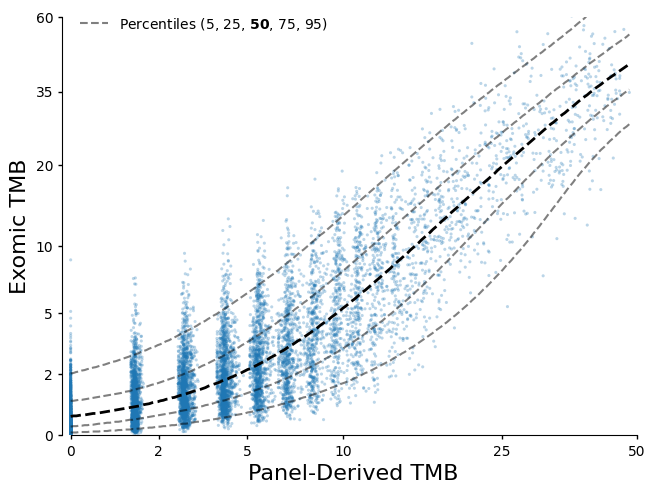

In [14]:
x_pred = np.linspace(np.min(X), np.max(X), 200)
pred_quantiles = [y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.05).astype(int), axis=0), axis=0)],
             y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.25).astype(int), axis=0), axis=0)],
             y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.5).astype(int), axis=0), axis=0)],
             y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.75).astype(int), axis=0), axis=0)],
            y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.95).astype(int), axis=0), axis=0)]]

fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.98,
bottom=0.108,
left=0.1,
right=.987,
hspace=0.2,
wspace=0.2)
ax.scatter(X, Y, s=5, edgecolor='none', alpha=.3)
for i in range(len(pred_quantiles)):
    if i == 0:
        ax.plot(x_pred, pred_quantiles[i], color='k', linestyle='dashed', alpha=.5, label='Percentiles (5, 25, ' + r'$\bf{50}$' + ', 75, 95)')
    elif i == 2:
        ax.plot(x_pred, pred_quantiles[i], color='k', linewidth=2, linestyle='dashed', alpha=1)
    else:
        ax.plot(x_pred, pred_quantiles[i], color='k', linestyle='dashed', alpha=.5)
ax.set_xticks([t.trf(i) for i in [0, 2, 5, 10, 25, 50]])
ax.set_xticklabels([0, 2, 5, 10, 25, 50])
ax.set_yticks([t.trf(i) for i in [0, 2, 5, 10, 20, 35, 60]])
ax.set_yticklabels([0, 2, 5, 10, 20, 35, 60], fontsize=12)
ax.set_xlabel('Panel-Derived TMB', fontsize=16)
ax.set_ylabel('Exomic TMB', fontsize=16)
ax.tick_params(length=3, width=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(['outward', 5])
ax.spines['left'].set_bounds(t.trf(0), t.trf(60))
ax.spines['bottom'].set_bounds(t.trf(0), t.trf(50))
plt.legend(frameon=False, loc=(.01, .95), fontsize=10)
ax.set_ylim(t.trf(0), t.trf(60))
ax.set_xlim(-.01, t.trf(50))

## Check the benefit of the fit

## Get predictions (we use median in this example)

In [16]:
medians = y_pred[np.argmin(np.diff((np.exp(net.model(X).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.5).astype(int), axis=0), axis=0)]

## Mean absolute error for panel-derived TMB (the input to the model)

In [17]:
np.mean(np.abs(t.inv(Y) - t.inv(X[:, 0])))

2.7034291921881137

## Mean absolute error for model predictions

In [18]:
print(np.mean(np.abs(t.inv(Y) - t.inv(medians))))

1.607252922233994


## You may only be interested in TMB values in a certain range, for example panel-derived TMB greater or equal than 5.  Here we also see a large improvement.

In [19]:
mask = t.inv(X[:, 0]) >= 5

## Mean absolute error for panel-derived TMB (the input to the model)

In [20]:
np.mean(np.abs(t.inv(Y[mask]) - t.inv(X[:, 0][mask])))

4.711436125160831

## mean absolute error for predictions

In [21]:
np.mean(np.abs(t.inv(Y[mask]) - t.inv(medians[mask])))

2.813154451164183

## Load data to make predictions on (here they are just a range of theoretical inputs)

In [22]:
x_pred = t.trf(pd.read_csv(cwd / 'example' / 'example_prediction_data.txt')['panel_data'].values)[:, np.newaxis]

In [24]:
quantiles = [y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.05).astype(int), axis=0), axis=0)],
             y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.25).astype(int), axis=0), axis=0)],
             y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.5).astype(int), axis=0), axis=0)],
             y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.75).astype(int), axis=0), axis=0)],
            y_pred[np.argmin(np.diff((np.exp(net.model(x_pred).log_cdf(y_pred[:, np.newaxis]).numpy()) < 0.95).astype(int), axis=0), axis=0)]]

## Write the predictions to a file.

In [26]:
pd.DataFrame(data={'5th percentile': t.inv(quantiles[0]),
                   '25th percentile': t.inv(quantiles[1]),
                   '50th percentile': t.inv(quantiles[2]),
                   '75th percentile': t.inv(quantiles[3]),
                   '95th percentile': t.inv(quantiles[4])}).to_csv(cwd / 'example' / 'example_predictions.txt', index=False, sep='\t')